In [ ]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
# 🧱 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os


# Path to the ZIP file in your Drive
zip_path = "/content/drive/MyDrive/AI_Emotion_Project/archive.zip"
extract_folder = "ravdess_data"
os.makedirs(extract_folder, exist_ok=True)

# Unzip it to the working directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("✅ Files extracted successfully!")


✅ Files extracted successfully!


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/ravdess_data/01-01-01-01-01-01-01.csv')
for column in df.columns:
    print(f"{column}: {df.iloc[1][column]}")


frame: 2.0
timestamp: 0.033
confidence: 0.98
gaze_0_x: 0.170199
gaze_0_y: 0.301091
gaze_0_z: -0.938284
gaze_1_x: -0.077985
gaze_1_y: 0.228398
gaze_1_z: -0.97044
gaze_angle_x: 0.048
gaze_angle_y: 0.271
eye_lmk_x_0: 565.8
eye_lmk_x_1: 568.9
eye_lmk_x_2: 577.9
eye_lmk_x_3: 587.6
eye_lmk_x_4: 592.3
eye_lmk_x_5: 590.0
eye_lmk_x_6: 580.2
eye_lmk_x_7: 570.5
eye_lmk_x_8: 550.0
eye_lmk_x_9: 555.4
eye_lmk_x_10: 563.1
eye_lmk_x_11: 573.3
eye_lmk_x_12: 584.1
eye_lmk_x_13: 593.2
eye_lmk_x_14: 600.6
eye_lmk_x_15: 594.1
eye_lmk_x_16: 584.0
eye_lmk_x_17: 573.4
eye_lmk_x_18: 564.0
eye_lmk_x_19: 555.9
eye_lmk_x_20: 575.9
eye_lmk_x_21: 579.6
eye_lmk_x_22: 583.0
eye_lmk_x_23: 584.2
eye_lmk_x_24: 582.4
eye_lmk_x_25: 578.7
eye_lmk_x_26: 575.2
eye_lmk_x_27: 574.1
eye_lmk_x_28: 705.4
eye_lmk_x_29: 710.6
eye_lmk_x_30: 720.6
eye_lmk_x_31: 729.7
eye_lmk_x_32: 732.5
eye_lmk_x_33: 727.4
eye_lmk_x_34: 717.4
eye_lmk_x_35: 707.4
eye_lmk_x_36: 695.8
eye_lmk_x_37: 703.0
eye_lmk_x_38: 712.0
eye_lmk_x_39: 721.8
eye_lmk_x

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import joblib

# === Step 0: Emotion label mapping ===
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# === Required columns for cleaning and feature extraction ===
required_columns = [
    "eye_lmk_y_43", "eye_lmk_y_47", "eye_lmk_x_42", "eye_lmk_x_45",
    "x_54", "x_48", "y_66", "y_62",
    "AU06_r", "AU12_r", "AU04_r", "AU01_r", "AU10_r", "AU09_r",
    "AU20_r", "AU14_r", "AU45_r", "AU25_r", "AU26_r",
    "pose_Rx", "pose_Ry", "pose_Rz",
    "gaze_angle_x", "gaze_angle_y"
]

# === Step 1: Clean and average middle 10 rows ===
def clean_and_average_df(df):
    df_clean = df.dropna(subset=required_columns)
    for col in required_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= Q1 - 1.5 * IQR) & (df_clean[col] <= Q3 + 1.5 * IQR)]
    if df_clean.empty:
        return None
    mid = len(df_clean) // 2
    chunk = df_clean.iloc[max(0, mid - 5): min(len(df_clean), mid + 5)]
    return chunk.mean(numeric_only=True)

# === Step 2: Feature extraction ===
def extract_features(row):
    return {
        "eye_openness": abs(row["eye_lmk_y_43"] - row["eye_lmk_y_47"]),
        "eye_width": abs(row["eye_lmk_x_42"] - row["eye_lmk_x_45"]),
        "mouth_width": abs(row["x_54"] - row["x_48"]),
        "mouth_openness": abs(row["y_66"] - row["y_62"]),
        "AU06_r": row["AU06_r"], "AU12_r": row["AU12_r"],
        "AU04_r": row["AU04_r"], "AU01_r": row["AU01_r"],
        "AU10_r": row["AU10_r"], "AU09_r": row["AU09_r"],
        "AU20_r": row["AU20_r"], "AU14_r": row["AU14_r"],
        "AU45_r": row["AU45_r"], "AU25_r": row["AU25_r"], "AU26_r": row["AU26_r"],
        "pose_Rx": row["pose_Rx"], "pose_Ry": row["pose_Ry"], "pose_Rz": row["pose_Rz"],
        "gaze_angle_x": row["gaze_angle_x"], "gaze_angle_y": row["gaze_angle_y"]
    }

# === Step 3: Extract emotion label from filename ===
def extract_emotion_from_filename(filename):
    parts = filename.split("-")
    if len(parts) >= 3:
        emotion_code = parts[2]
        return emotion_map.get(emotion_code, "unknown")
    return "unknown"

# === Step 4: Process all CSVs and build features ===
all_features = []
for filename in tqdm(os.listdir(extract_folder)):
    if not filename.endswith(".csv"):
        continue
    try:
        df = pd.read_csv(os.path.join(extract_folder, filename))
        avg_row = clean_and_average_df(df)
        if avg_row is None or any(pd.isna(avg_row.get(col)) for col in required_columns):
            continue
        features = extract_features(avg_row)
        features["file"] = filename
        features["label"] = extract_emotion_from_filename(filename)
        all_features.append(features)
    except Exception as e:
        print(f"Error processing {filename}: {e}")



100%|██████████| 2452/2452 [03:17<00:00, 12.39it/s]


In [ ]:
import joblib
# === Step 5: Normalize ===
features_df = pd.DataFrame(all_features)
columns_to_scale = [col for col in features_df.columns if col not in ["file", "label"]]
scaler = MinMaxScaler()
normalized = scaler.fit_transform(features_df[columns_to_scale])
normalized_df = pd.DataFrame(normalized, columns=columns_to_scale)
normalized_df["file"] = features_df["file"]
normalized_df["label"] = features_df["label"]

# === Step 6: Save results ===
joblib.dump(scaler, '/content/drive/MyDrive/AI_Emotion_Project3/minmax_scaler.pkl')
normalized_df.to_csv("normalized_features_with_labels.csv", index=False)
print("✅ Normalized features with labels saved to normalized_features_with_labels.csv")



✅ Normalized features with labels saved to normalized_features_with_labels.csv


In [ ]:

# 📂 Path to your file in Drive
csv_path = '/content/normalized_features_with_labels.csv'

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Load and fill missing values if any
df = pd.read_csv(csv_path)


print(df.describe())


       eye_openness    eye_width  mouth_width  mouth_openness       AU06_r  \
count   2452.000000  2452.000000  2452.000000     2452.000000  2452.000000   
mean       0.155196     0.411202     0.499218        0.248581     0.108154   
std        0.132087     0.127497     0.137279        0.146164     0.182836   
min        0.000000     0.000000     0.000000        0.000000     0.000000   
25%        0.058661     0.326071     0.410688        0.142266     0.000000   
50%        0.119160     0.402629     0.489145        0.230745     0.000000   
75%        0.217454     0.491358     0.576617        0.341224     0.155878   
max        1.000000     1.000000     1.000000        1.000000     1.000000   

            AU12_r       AU04_r       AU01_r       AU10_r       AU09_r  \
count  2452.000000  2452.000000  2452.000000  2452.000000  2452.000000   
mean      0.140703     0.128754     0.216291     0.179258     0.108458   
std       0.203483     0.173878     0.236212     0.225681     0.152454   
m

In [ ]:
# 📥 Load the CSV and handle NaNs

df = pd.read_csv(csv_path)

# Define fuzzy input variables
mouth_openness = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'mouth_openness')
eye_openness = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'eye_openness')
AU06 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU06')
AU12 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU12')
AU04 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU04')
AU01 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU01')
AU45 = ctrl.Antecedent(np.linspace(0, 2.5, 100), 'AU45')  # wider range
emotion = ctrl.Consequent(np.linspace(0, 100, 100), 'emotion')

# Membership functions
for var in [mouth_openness, eye_openness, AU06, AU12, AU04, AU01]:
    var['low'] = fuzz.trimf(var.universe, [0.0, 0.0, 0.07])
    var['medium'] = fuzz.trimf(var.universe, [0.05, 0.1, 0.15])
    var['high'] = fuzz.trimf(var.universe, [0.13, 0.2, 0.2])

AU45['low'] = fuzz.trimf(AU45.universe, [0.0, 0.0, 1.0])
AU45['high'] = fuzz.trimf(AU45.universe, [1.5, 2.5, 2.5])

emotion['neutral'] = fuzz.trimf(emotion.universe, [0, 0, 25])
emotion['happy'] = fuzz.trimf(emotion.universe, [20, 40, 60])
emotion['surprised'] = fuzz.trimf(emotion.universe, [50, 70, 90])
emotion['sad'] = fuzz.trimf(emotion.universe, [70, 100, 100])

# Rules
rules = [
    ctrl.Rule(mouth_openness['high'] & eye_openness['high'], emotion['surprised']),
    ctrl.Rule(AU12['high'] & AU06['high'], emotion['happy']),
    ctrl.Rule(AU01['high'] & AU04['high'], emotion['sad']),
    ctrl.Rule(AU12['low'] & AU06['low'], emotion['neutral']),
    ctrl.Rule(AU01['medium'] & AU04['medium'], emotion['sad']),
    ctrl.Rule(eye_openness['low'] & mouth_openness['low'], emotion['neutral']),
    ctrl.Rule(AU45['high'], emotion['surprised'])
]

# Build and simulate fuzzy system
emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Run fuzzy logic for each row
results = []
for i, row in df.iterrows():
    try:
        emotion_sim.input['mouth_openness'] = row['mouth_openness']
        emotion_sim.input['eye_openness'] = row['eye_openness']
        emotion_sim.input['AU06'] = row['AU06_r']
        emotion_sim.input['AU12'] = row['AU12_r']
        emotion_sim.input['AU04'] = row['AU04_r']
        emotion_sim.input['AU01'] = row['AU01_r']
        emotion_sim.input['AU45'] = row['AU45_r']
        emotion_sim.compute()
        results.append((row['file'], emotion_sim.output['emotion']))
    except Exception as e:
        results.append((row['file'], "Error"))

# Save results to CSV in Drive
output_df = pd.DataFrame(results, columns=["file", "emotion_score"])
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores.csv"
output_df.to_csv(output_path, index=False)

print(f"✅ All done! Saved results to: {output_path}")

✅ All done! Saved results to: /content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores.csv


In [ ]:

# Load emotion scores and features
emotion_df = pd.read_csv('/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores.csv')
features_df = pd.read_csv('/content/normalized_features_with_labels.csv')

# 1. Extract "Error" files
error_files = emotion_df[emotion_df['emotion_score'] == 'Error']['file'].tolist()

print(f"🔍 Found {len(error_files)} files with errors.")

# 2. Review their original features
error_rows = features_df[features_df['file'].isin(error_files)]

# Show some examples with NaNs or unusual values
print("\n🔎 Example of problematic rows:")
print(error_rows.describe(include='all'))


🔍 Found 303 files with errors.

🔎 Example of problematic rows:
        eye_openness   eye_width  mouth_width  mouth_openness      AU06_r  \
count     303.000000  303.000000   303.000000      303.000000  303.000000   
unique           NaN         NaN          NaN             NaN         NaN   
top              NaN         NaN          NaN             NaN         NaN   
freq             NaN         NaN          NaN             NaN         NaN   
mean        0.099114    0.389082     0.490786        0.237115    0.073890   
std         0.096471    0.125542     0.120026        0.136788    0.111774   
min         0.000000    0.116845     0.062803        0.000000    0.000000   
25%         0.035696    0.305015     0.421310        0.123727    0.000000   
50%         0.079790    0.381694     0.510529        0.222311    0.026629   
75%         0.114173    0.461052     0.564433        0.331318    0.108074   
max         0.597900    0.713729     0.760250        0.827976    0.639943   

            

In [ ]:

# Load your fuzzy emotion output
fuzzy_output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores.csv"
df_fuzzy = pd.read_csv(fuzzy_output_path)

# Filter only the rows that had an error during fuzzy logic
df_errors = df_fuzzy[df_fuzzy['emotion_score'] == "Error"]

# Save just the filenames of problematic files
error_files = df_errors['file']
error_files_path = "/content/drive/MyDrive/AI_Emotion_Project3/error_files.csv"
error_files.to_csv(error_files_path, index=False)

print(f"✅ Saved list of {len(error_files)} error files to:\n{error_files_path}")


✅ Saved list of 303 error files to:
/content/drive/MyDrive/AI_Emotion_Project3/error_files.csv


In [ ]:
# Path setup
error_files_path = "/content/drive/MyDrive/AI_Emotion_Project3/error_files.csv"
extract_folder = "/content/ravdess_data"
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/normalized_features_errors_fixed.csv"

# Load error filenames
error_files = pd.read_csv(error_files_path)['file'].tolist()

# Columns needed for processing
required_columns = [
    "eye_lmk_y_43", "eye_lmk_y_47", "eye_lmk_x_42", "eye_lmk_x_45",
    "x_54", "x_48", "y_66", "y_62",
    "AU06_r", "AU12_r", "AU04_r", "AU01_r", "AU10_r", "AU09_r",
    "AU20_r", "AU14_r", "AU45_r",
    "pose_Rx", "pose_Ry", "pose_Rz",
    "gaze_angle_x", "gaze_angle_y"
]

# Cleaning and averaging
def clean_and_average_df(df):
    df_clean = df.dropna(subset=required_columns)
    for col in required_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= Q1 - 1.5 * IQR) & (df_clean[col] <= Q3 + 1.5 * IQR)]
    if df_clean.empty:
        return None
    mid = len(df_clean) // 2
    chunk = df_clean.iloc[max(0, mid - 5): min(len(df_clean), mid + 5)]
    return chunk.mean(numeric_only=True)

# Feature extraction logic
def extract_features(row):
    return {
        "eye_openness": abs(row["eye_lmk_y_43"] - row["eye_lmk_y_47"]),
        "eye_width": abs(row["eye_lmk_x_42"] - row["eye_lmk_x_45"]),
        "mouth_width": abs(row["x_54"] - row["x_48"]),
        "mouth_openness": abs(row["y_66"] - row["y_62"]),
        "AU06_r": row["AU06_r"], "AU12_r": row["AU12_r"],
        "AU04_r": row["AU04_r"], "AU01_r": row["AU01_r"],
        "AU10_r": row["AU10_r"], "AU09_r": row["AU09_r"],
        "AU20_r": row["AU20_r"], "AU14_r": row["AU14_r"],
        "AU45_r": row["AU45_r"],
        "pose_Rx": row["pose_Rx"], "pose_Ry": row["pose_Ry"], "pose_Rz": row["pose_Rz"],
        "gaze_angle_x": row["gaze_angle_x"], "gaze_angle_y": row["gaze_angle_y"]
    }

# Process each error file
fixed_features = []
for filename in tqdm(error_files, desc="Fixing error files"):
    try:
        full_path = os.path.join(extract_folder, filename)
        df = pd.read_csv(full_path)
        avg_row = clean_and_average_df(df)
        if avg_row is None or any(pd.isna(avg_row.get(col)) for col in required_columns):
            continue
        features = extract_features(avg_row)
        features["file"] = filename
        fixed_features.append(features)
    except Exception as e:
        print(f"❌ Error fixing {filename}: {e}")

# Normalize fixed features
if fixed_features:
    fixed_df = pd.DataFrame(fixed_features)
    columns_to_scale = [col for col in fixed_df.columns if col != "file"]
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(fixed_df[columns_to_scale])
    normalized_df = pd.DataFrame(normalized, columns=columns_to_scale)
    normalized_df["file"] = fixed_df["file"]
    normalized_df.to_csv(output_path, index=False)
    print(f"✅ Fixed and saved {len(normalized_df)} files to {output_path}")
else:
    print("⚠️ No valid files were recovered.")


Fixing error files: 100%|██████████| 303/303 [00:20<00:00, 14.45it/s]


✅ Fixed and saved 303 files to /content/drive/MyDrive/AI_Emotion_Project3/normalized_features_errors_fixed.csv


In [ ]:

# Load cleaned + normalized dataset
csv_path = "/content/drive/MyDrive/AI_Emotion_Project3/normalized_features_errors_fixed.csv"
df = pd.read_csv(csv_path)

# Define fuzzy input variables
mouth_openness = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'mouth_openness')
eye_openness = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'eye_openness')
AU06 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU06')
AU12 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU12')
AU04 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU04')
AU01 = ctrl.Antecedent(np.linspace(0,  0.2, 100), 'AU01')
AU45 = ctrl.Antecedent(np.linspace(0, 2.5, 100), 'AU45')
emotion = ctrl.Consequent(np.linspace(0, 100, 100), 'emotion')

# Membership functions
for var in [mouth_openness, eye_openness, AU06, AU12, AU04, AU01]:
    var['low'] = fuzz.trimf(var.universe, [0.0, 0.0, 0.07])
    var['medium'] = fuzz.trimf(var.universe, [0.05, 0.1, 0.15])
    var['high'] = fuzz.trimf(var.universe, [0.13, 0.2, 0.2])

AU45['low'] = fuzz.trimf(AU45.universe, [0.0, 0.0, 1.0])
AU45['high'] = fuzz.trimf(AU45.universe, [1.5, 2.5, 2.5])

emotion['neutral'] = fuzz.trimf(emotion.universe, [0, 0, 25])
emotion['happy'] = fuzz.trimf(emotion.universe, [20, 40, 60])
emotion['surprised'] = fuzz.trimf(emotion.universe, [50, 70, 90])
emotion['sad'] = fuzz.trimf(emotion.universe, [70, 100, 100])

# Define rules
rules = [
    ctrl.Rule(mouth_openness['high'] & eye_openness['high'], emotion['surprised']),
    ctrl.Rule(AU12['high'] & AU06['high'], emotion['happy']),
    ctrl.Rule(AU01['high'] & AU04['high'], emotion['sad']),
    ctrl.Rule(AU12['low'] & AU06['low'], emotion['neutral']),
    ctrl.Rule(AU01['medium'] & AU04['medium'], emotion['sad']),
    ctrl.Rule(eye_openness['low'] & mouth_openness['low'], emotion['neutral']),
    ctrl.Rule(AU45['high'], emotion['surprised'])
]

# Build and simulate fuzzy system
emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Run fuzzy logic for each row
results = []
for i, row in df.iterrows():
    try:
        emotion_sim.input['mouth_openness'] = row['mouth_openness']
        emotion_sim.input['eye_openness'] = row['eye_openness']
        emotion_sim.input['AU06'] = row['AU06_r']
        emotion_sim.input['AU12'] = row['AU12_r']
        emotion_sim.input['AU04'] = row['AU04_r']
        emotion_sim.input['AU01'] = row['AU01_r']
        emotion_sim.input['AU45'] = row['AU45_r']
        emotion_sim.compute()
        results.append((row['file'], emotion_sim.output['emotion']))
    except Exception as e:
        results.append((row['file'], "Error"))

# Save results
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_errors_fixed.csv"
output_df = pd.DataFrame(results, columns=["file", "emotion_score"])
output_df.to_csv(output_path, index=False)

print(f"✅ Fuzzy emotion scores saved to: {output_path}")


✅ Fuzzy emotion scores saved to: /content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_errors_fixed.csv


In [ ]:


# Load the normalized fixed features
csv_path = "/content/drive/MyDrive/AI_Emotion_Project3/normalized_features_errors_fixed.csv"
df = pd.read_csv(csv_path)

# Drop rows with any NaNs to avoid compute errors
df = df.dropna()

# Define fuzzy input variables
mouth_openness = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'mouth_openness')
eye_openness = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'eye_openness')
AU06 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU06')
AU12 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU12')
AU04 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU04')
AU01 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU01')
AU45 = ctrl.Antecedent(np.linspace(0, 2.5, 100), 'AU45')
emotion = ctrl.Consequent(np.linspace(0, 100, 100), 'emotion')

# Membership functions
for var in [mouth_openness, eye_openness, AU06, AU12, AU04, AU01]:
    var['low'] = fuzz.trimf(var.universe, [0.0, 0.0, 0.07])
    var['medium'] = fuzz.trimf(var.universe, [0.05, 0.1, 0.15])
    var['high'] = fuzz.trimf(var.universe, [0.13, 0.2, 0.2])

AU45['low'] = fuzz.trimf(AU45.universe, [0.0, 0.0, 1.0])
AU45['high'] = fuzz.trimf(AU45.universe, [1.5, 2.5, 2.5])

emotion['neutral'] = fuzz.trimf(emotion.universe, [0, 0, 25])
emotion['happy'] = fuzz.trimf(emotion.universe, [20, 40, 60])
emotion['surprised'] = fuzz.trimf(emotion.universe, [50, 70, 90])
emotion['sad'] = fuzz.trimf(emotion.universe, [70, 100, 100])

# Define rules
rules = [
    ctrl.Rule(mouth_openness['high'] & eye_openness['high'], emotion['surprised']),
    ctrl.Rule(AU12['high'] & AU06['high'], emotion['happy']),
    ctrl.Rule(AU01['high'] & AU04['high'], emotion['sad']),
    ctrl.Rule(AU12['low'] & AU06['low'], emotion['neutral']),
    ctrl.Rule(AU01['medium'] & AU04['medium'], emotion['sad']),
    ctrl.Rule(eye_openness['low'] & mouth_openness['low'], emotion['neutral']),
    ctrl.Rule(AU45['high'], emotion['surprised'])
]

# Build fuzzy system
emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Process each row
results = []

for _, row in df.iterrows():
    try:
        emotion_sim.input['mouth_openness'] = row['mouth_openness']
        emotion_sim.input['eye_openness'] = row['eye_openness']
        emotion_sim.input['AU06'] = row['AU06_r']
        emotion_sim.input['AU12'] = row['AU12_r']
        emotion_sim.input['AU04'] = row['AU04_r']
        emotion_sim.input['AU01'] = row['AU01_r']
        emotion_sim.input['AU45'] = row['AU45_r']

        emotion_sim.compute()
        score = emotion_sim.output['emotion']
        results.append((row['file'], score))
    except Exception as e:
        results.append((row['file'], "Error"))

# Save results
output_df = pd.DataFrame(results, columns=["file", "emotion_score"])
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_errors_fixed_2.0.csv"
output_df.to_csv(output_path, index=False)

print(f"✅ Fuzzy emotion scores saved to: {output_path}")


✅ Fuzzy emotion scores saved to: /content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_errors_fixed_2.0.csv


In [ ]:

# Load original fuzzy emotion scores
input_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores.csv"
df = pd.read_csv(input_path)

# Drop rows where emotion_score is "Error"
clean_df = df[df["emotion_score"] != "Error"]

# Optional: convert emotion_score to float for modeling (if needed)
clean_df["emotion_score"] = clean_df["emotion_score"].astype(float)

# Save cleaned CSV
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_large.csv"
clean_df.to_csv(output_path, index=False)

print(f"✅ Cleaned file saved to: {output_path}")
print(f"🧹 Dropped {len(df) - len(clean_df)} error rows. Final rows: {len(clean_df)}")


<ipython-input-16-62e165fbc203>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["emotion_score"] = clean_df["emotion_score"].astype(float)


✅ Cleaned file saved to: /content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_large.csv
🧹 Dropped 303 error rows. Final rows: 2149


In [ ]:
input_path2 = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_errors_fixed_2.0.csv"
df = pd.read_csv(input_path2)

# Drop rows where emotion_score is "Error"
clean_df = df[df["emotion_score"] != "Error"]

# Optional: convert emotion_score to float for modeling (if needed)
clean_df["emotion_score"] = clean_df["emotion_score"].astype(float)

# Save cleaned CSV
output_path = "/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_small.csv"
clean_df.to_csv(output_path, index=False)

print(f"✅ Cleaned file saved to: {output_path}")

<ipython-input-17-9e8010569a61>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["emotion_score"] = clean_df["emotion_score"].astype(float)


✅ Cleaned file saved to: /content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_small.csv


In [ ]:

# Load original and fixed CSVs
original_df = pd.read_csv("/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_large.csv")
fixed_df = pd.read_csv("/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_scores_small.csv")

# Remove the old error rows from the original file
# Assumes 'file' column identifies each row uniquely
cleaned_original_df = original_df[~original_df['file'].isin(fixed_df['file'])]

# Append the fixed rows
final_df = pd.concat([cleaned_original_df, fixed_df], ignore_index=True)

# Sort if needed
final_df = final_df.sort_values("file").reset_index(drop=True)

# Save the updated file
final_df.to_csv("/content/drive/MyDrive/AI_Emotion_Project3/scores_final.csv", index=False)
print("✅ Updated dataset saved as fuzzy_emotion_scores_final.csv")


✅ Updated dataset saved as fuzzy_emotion_scores_final.csv


In [ ]:
def classify_emotion(row):
    score = row['emotion_score']
    au06 = row.get('AU06_r', 0)
    au12 = row.get('AU12_r', 0)
    au01 = row.get('AU01_r', 0)
    au04 = row.get('AU04_r', 0)
    au45 = row.get('AU45_r', 0)

    if score < 20:
        return "neutral"
    elif score < 35:
        return "calm"
    elif score < 50:
        return "happy"
    elif score < 65 and (au06 > 0.4 or au12 > 0.4):
        return "excited"
    elif score < 80:
        return "surprised"
    elif score < 90 and au45 > 2:
        return "shocked"
    elif score >= 90 and (au01 > 0.4 or au04 > 0.4):
        return "sad"
    elif score > 85 and all(val < 0.2 for val in [au06, au12, au01, au04, au45]):
        return "angry"

    else:
        return "unknown"



In [ ]:
# Load final fuzzy scores file
df = pd.read_csv("/content/drive/MyDrive/AI_Emotion_Project3/scores_final.csv")



# Apply emotion classification
df['emotion_label'] = df.apply(classify_emotion, axis=1)

# Save the result
df.to_csv("/content/drive/MyDrive/AI_Emotion_Project3/fuzzy_emotion_labeled_extended.csv", index=False)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving surprised sad confused crying.csv to surprised sad confused crying.csv


In [ ]:

from sklearn.metrics import classification_report

# === Load scaler and reference data ===
scaler = joblib.load("/content/drive/MyDrive/AI_Emotion_Project3/minmax_scaler.pkl")
reference_df = pd.read_csv("/content/normalized_features_with_labels.csv")

# === Define fuzzy variables ===
mouth_openness = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'mouth_openness')
eye_openness = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'eye_openness')
AU12 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU12')
AU06 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU06')
AU04 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU04')
AU01 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU01')
AU09 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU09')
AU10 = ctrl.Antecedent(np.linspace(0, 0.2, 100), 'AU10')

emotion = ctrl.Consequent(np.linspace(0, 100, 100), 'emotion')

for var in [mouth_openness, eye_openness, AU12, AU06, AU04, AU01, AU09, AU10]:
    var['low'] = fuzz.trimf(var.universe, [0.0, 0.0, 0.05])
    var['medium'] = fuzz.trimf(var.universe, [0.04, 0.08, 0.12])
    var['high'] = fuzz.trimf(var.universe, [0.1, 0.2, 0.2])

emotion['neutral'] = fuzz.trimf(emotion.universe, [0, 0, 15])
emotion['happy'] = fuzz.trimf(emotion.universe, [15, 25, 35])
emotion['disgust'] = fuzz.trimf(emotion.universe, [35, 50, 65])
emotion['surprised'] = fuzz.trimf(emotion.universe, [65, 80, 90])
emotion['angry'] = fuzz.trimf(emotion.universe, [90, 100, 100])

# === Rules ===
rules = [
    ctrl.Rule(AU12['high'] & AU06['high'] & mouth_openness['high'], emotion['happy']),
    ctrl.Rule(AU04['high'] & AU01['low'], emotion['angry']),
    ctrl.Rule(AU12['low'] & AU06['low'] & AU04['low'] & AU01['low'], emotion['neutral']),
    ctrl.Rule(AU09['high'] & AU10['medium'], emotion['disgust']),
    ctrl.Rule(mouth_openness['medium'] & eye_openness['medium'], emotion['surprised'])
]

emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# === Feature extraction ===
def extract_features(row):
    return {
        "eye_openness": abs(row["eye_lmk_y_43"] - row["eye_lmk_y_47"]),
        "mouth_openness": abs(row["y_66"] - row["y_62"]),
        "AU06_r": row["AU06_r"], "AU12_r": row["AU12_r"],
        "AU04_r": row["AU04_r"], "AU01_r": row["AU01_r"],
        "AU10_r": row["AU10_r"], "AU09_r": row["AU09_r"]
    }

# === Emotion classification ===
def classify_emotion(score):
    if score < 15:
        return "neutral"
    elif score < 35:
        return "happy"
    elif score < 65:
        return "disgust"
    elif score < 90:
        return "surprised"
    else:
        return "angry"

# === Evaluate on reference dataset ===
pred_labels = []
true_labels = []

for _, row in reference_df.iterrows():
    try:
        feats = {key: row[key] for key in reference_df.columns if key not in ["file", "label"]}
        raw_df = pd.DataFrame([feats])
        inv_scaled = scaler.inverse_transform(raw_df)
        raw_feats = dict(zip(raw_df.columns, inv_scaled[0]))

        emotion_sim.input['mouth_openness'] = feats['mouth_openness']
        emotion_sim.input['eye_openness'] = feats['eye_openness']
        emotion_sim.input['AU06'] = feats['AU06_r']
        emotion_sim.input['AU12'] = feats['AU12_r']
        emotion_sim.input['AU04'] = feats['AU04_r']
        emotion_sim.input['AU01'] = feats['AU01_r']
        emotion_sim.input['AU09'] = feats['AU09_r']
        emotion_sim.input['AU10'] = feats['AU10_r']

        emotion_sim.compute()
        score = emotion_sim.output['emotion']

        label = classify_emotion(score)
        pred_labels.append(label)
        true_labels.append(row["label"])

    except Exception as e:
        continue

# === Evaluation ===
print("\n🔍 Evaluation Report on 2400+ Labeled Files:")
print(classification_report(true_labels, pred_labels))



🔍 Evaluation Report on 2400+ Labeled Files:
              precision    recall  f1-score   support

       angry       0.48      0.47      0.47       234
        calm       0.00      0.00      0.00       138
     disgust       0.16      0.20      0.17       107
     fearful       0.00      0.00      0.00        96
       happy       0.57      0.93      0.71       312
     neutral       0.22      0.58      0.32        77
         sad       0.00      0.00      0.00       138
   surprised       0.04      0.05      0.05        73

    accuracy                           0.40      1175
   macro avg       0.18      0.28      0.21      1175
weighted avg       0.28      0.40      0.32      1175



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load your dataset
data = pd.read_csv('/content/normalized_features_with_labels.csv')  # Replace with your correct filename

# Separate features and target
X = data.drop(columns=['file', 'label'])  # Drop filename and target column
y = data['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply class_weight='balanced' to fix class imbalance
model = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(model, 'fuzzy_emotion_rf_balanced2.pkl')


Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.91      0.91        75
        calm       0.72      0.88      0.79        75
     disgust       0.67      0.77      0.71        39
     fearful       0.73      0.73      0.73        75
       happy       0.82      0.85      0.84        75
     neutral       0.74      0.74      0.74        38
         sad       0.75      0.69      0.72        75
   surprised       0.74      0.36      0.48        39

    accuracy                           0.77       491
   macro avg       0.76      0.74      0.74       491
weighted avg       0.77      0.77      0.76       491


Confusion Matrix:
[[68  1  2  1  0  2  1  0]
 [ 0 66  1  3  4  1  0  0]
 [ 0  1 30  2  0  2  4  0]
 [ 3  1  4 55  3  0  6  3]
 [ 0  7  1  1 64  1  1  0]
 [ 0  3  0  2  1 28  2  2]
 [ 1 10  5  4  2  1 52  0]
 [ 3  3  2  7  4  3  3 14]]


['fuzzy_emotion_rf_balanced2.pkl']

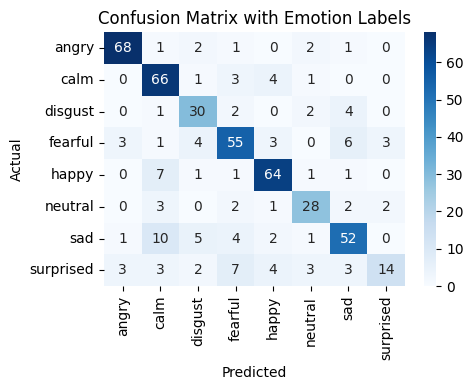

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your true and predicted labels
y_true = y_test
y_pred = model.predict(X_test)

# Define class labels in order (make sure they match your actual label encoding!)
labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Emotion Labels")
plt.tight_layout()
plt.show()


In [ ]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === Load webcam CSV ===
df = pd.read_csv("/content/surprised sad confused crying.csv")
df.columns = df.columns.str.strip()

required_columns = [
    "timestamp",
    "eye_lmk_y_43", "eye_lmk_y_47", "eye_lmk_x_42", "eye_lmk_x_45",
    "x_54", "x_48", "y_66", "y_62",
    "AU06_r", "AU12_r", "AU04_r", "AU01_r", "AU10_r",
    "AU09_r", "AU20_r", "AU14_r",
    "AU45_r", "AU25_r", "AU26_r",
    "pose_Rx", "pose_Ry", "pose_Rz",
    "gaze_angle_x", "gaze_angle_y"
]
df = df.dropna(subset=required_columns)

def extract_features(row):
    return {
        "eye_openness": abs(row["eye_lmk_y_43"] - row["eye_lmk_y_47"]),
        "eye_width": abs(row["eye_lmk_x_42"] - row["eye_lmk_x_45"]),
        "mouth_width": abs(row["x_54"] - row["x_48"]),
        "mouth_openness": abs(row["y_66"] - row["y_62"]),
        "AU06_r": row["AU06_r"], "AU12_r": row["AU12_r"],
        "AU04_r": row["AU04_r"], "AU01_r": row["AU01_r"],
        "AU10_r": row["AU10_r"], "AU09_r": row["AU09_r"],
        "AU20_r": row["AU20_r"], "AU14_r": row["AU14_r"],
        "AU45_r": row["AU45_r"], "AU25_r": row["AU25_r"], "AU26_r": row["AU26_r"],
        "pose_Rx": row["pose_Rx"], "pose_Ry": row["pose_Ry"], "pose_Rz": row["pose_Rz"],
        "gaze_angle_x": row["gaze_angle_x"], "gaze_angle_y": row["gaze_angle_y"]
    }

# Load model and scaler
scaler = joblib.load("/content/drive/MyDrive/AI_Emotion_Project3/minmax_scaler.pkl")
model = joblib.load("fuzzy_emotion_rf_balanced2.pkl")

# === Print timestamp → emotion ===
for _, row in df.iterrows():
    try:
        feats = extract_features(row)
        scaled = scaler.transform(pd.DataFrame([feats]))
        predicted = model.predict(scaled)[0]
        print(f"{round(row['timestamp'], 2)}s → {predicted}")
    except:
        continue


0.98s → neutral
1.13s → neutral
1.16s → neutral
1.17s → neutral
1.25s → neutral
1.26s → neutral
1.32s → neutral
1.33s → neutral
1.38s → neutral
1.39s → neutral
1.45s → neutral
1.47s → neutral
1.52s → sad
1.65s → angry
1.71s → angry
1.76s → angry
1.8s → sad
1.85s → sad
1.92s → sad
1.96s → sad
2.01s → sad
2.05s → sad
2.11s → sad
2.15s → sad
2.2s → sad
2.24s → sad
2.28s → sad
2.32s → sad
2.38s → sad
2.42s → calm
2.46s → calm
2.51s → sad
2.57s → sad
2.61s → sad
2.66s → calm
2.7s → sad
2.76s → sad
2.8s → sad
2.85s → sad
2.91s → sad
2.94s → fearful
2.99s → fearful
3.04s → calm
3.1s → surprised
3.13s → surprised
3.18s → fearful
3.25s → fearful
3.29s → fearful
3.34s → sad
3.38s → sad
3.44s → happy
3.48s → happy
3.53s → happy
3.57s → fearful
3.63s → sad
3.67s → sad
3.72s → calm
3.77s → sad
3.81s → sad
3.86s → sad
3.9s → fearful
3.97s → sad
4.0s → sad
4.05s → sad
4.1s → sad
4.17s → calm
4.2s → calm
4.25s → calm
4.3s → calm
4.37s → calm
4.4s → sad
4.44s → calm
4.49s → calm
4.54s → calm
4.59s → ca

In [ ]:


# === Load OpenFace data ===
df = pd.read_csv("/content/surprised sad confused crying.csv")
df.columns = df.columns.str.strip()

# === Compute Eye Aspect Ratio (EAR) ===
def compute_eye_aspect_ratio(eye_indices, df):
    x_cols = [f'x_{i}' for i in eye_indices]
    y_cols = [f'y_{i}' for i in eye_indices]
    x_coords = df[x_cols].values
    y_coords = df[y_cols].values
    v1 = np.linalg.norm(np.stack([x_coords[:, 1] - x_coords[:, 5], y_coords[:, 1] - y_coords[:, 5]], axis=1), axis=1)
    v2 = np.linalg.norm(np.stack([x_coords[:, 2] - x_coords[:, 4], y_coords[:, 2] - y_coords[:, 4]], axis=1), axis=1)
    h = np.linalg.norm(np.stack([x_coords[:, 0] - x_coords[:, 3], y_coords[:, 0] - y_coords[:, 3]], axis=1), axis=1)
    return (v1 + v2) / (2.0 * h)

# Dlib 68-point indices for eyes
left_eye_indices = [36, 37, 38, 39, 40, 41]
right_eye_indices = [42, 43, 44, 45, 46, 47]
left_ear = compute_eye_aspect_ratio(left_eye_indices, df)
right_ear = compute_eye_aspect_ratio(right_eye_indices, df)
df['eye_openness'] = (left_ear + right_ear) / 2.0

# === Extract and normalize key features ===
features = ['AU06_r', 'AU12_r', 'AU01_r', 'AU04_r', 'AU45_r', 'eye_openness']
df = df.dropna(subset=features)  # Drop rows with missing values
data = df[features]
norm_data = (data - data.min()) / (data.max() - data.min())  # Min-max normalization

# === Define fuzzy variables ===
AU06 = ctrl.Antecedent(np.linspace(0, 1, 100), 'AU06')
AU12 = ctrl.Antecedent(np.linspace(0, 1, 100), 'AU12')
AU01 = ctrl.Antecedent(np.linspace(0, 1, 100), 'AU01')
AU04 = ctrl.Antecedent(np.linspace(0, 1, 100), 'AU04')
AU45 = ctrl.Antecedent(np.linspace(0, 1, 100), 'AU45')
eye_open = ctrl.Antecedent(np.linspace(0, 1, 100), 'eye_open')
emotion = ctrl.Consequent(np.linspace(0, 100, 100), 'emotion')

# Define membership functions
for au in [AU06, AU12, AU01, AU04, AU45, eye_open]:
    au['low'] = fuzz.trimf(au.universe, [0, 0, 0.5])
    au['high'] = fuzz.trimf(au.universe, [0.3, 1, 1])

emotion['neutral'] = fuzz.trimf(emotion.universe, [0, 0, 20])
emotion['happy'] = fuzz.trimf(emotion.universe, [20, 30, 40])
emotion['sad'] = fuzz.trimf(emotion.universe, [40, 50, 60])
emotion['surprised'] = fuzz.trimf(emotion.universe, [60, 70, 80])
emotion['angry'] = fuzz.trimf(emotion.universe, [80, 90, 100])

# === Define fuzzy rules ===
rules = [
    ctrl.Rule(AU06['high'] & AU12['high'], emotion['happy']),
    ctrl.Rule(AU01['high'] & AU04['high'], emotion['sad']),
    ctrl.Rule(AU04['high'] & AU12['low'], emotion['angry']),
    ctrl.Rule(AU01['high'] & AU45['high'] & eye_open['high'], emotion['surprised']),
    ctrl.Rule(AU06['low'] & AU12['low'] & AU04['low'], emotion['neutral']),
]

# === Build and simulate fuzzy system ===
emotion_ctrl = ctrl.ControlSystem(rules)
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Run prediction for each frame
predicted_emotions = []
for _, row in norm_data.iterrows():
    emotion_sim.input['AU06'] = row['AU06_r']
    emotion_sim.input['AU12'] = row['AU12_r']
    emotion_sim.input['AU01'] = row['AU01_r']
    emotion_sim.input['AU04'] = row['AU04_r']
    emotion_sim.input['AU45'] = row['AU45_r']
    emotion_sim.input['eye_open'] = row['eye_openness']
    try:
        emotion_sim.compute()
        fuzzy_val = emotion_sim.output['emotion']
        if fuzzy_val < 20:
            pred = 'neutral'
        elif fuzzy_val < 40:
            pred = 'happy'
        elif fuzzy_val < 60:
            pred = 'sad'
        elif fuzzy_val < 80:
            pred = 'surprised'
        else:
            pred = 'angry'
        predicted_emotions.append(pred)
    except:
        predicted_emotions.append('calm')

# Add predictions to DataFrame
df = df.loc[norm_data.index]  # Align with normalized rows
df['predicted_emotion'] = predicted_emotions

# Only print timestamp and detected emotion, suppress everything else
import sys
import os

# Redirect stderr to null to suppress unwanted errors/warnings
sys.stderr = open(os.devnull, 'w')

# Print timestamp and emotion only
for _, row in df.iterrows():
    print(f"{row['timestamp']:.2f}: {row['predicted_emotion']}")


1.52: neutral
1.65: happy
1.71: angry
1.76: angry
1.80: neutral
1.85: angry
1.92: angry
1.96: angry
2.01: surprised
2.05: neutral
2.11: neutral
2.15: neutral
2.20: happy
2.24: neutral
2.28: neutral
2.32: neutral
2.38: neutral
2.42: neutral
2.46: neutral
2.51: neutral
2.57: neutral
2.61: neutral
2.66: neutral
2.70: surprised
2.76: surprised
2.80: surprised
2.85: surprised
2.91: surprised
2.94: surprised
2.99: neutral
3.04: neutral
3.10: neutral
3.13: neutral
3.18: neutral
3.25: neutral
3.29: neutral
3.34: neutral
3.38: surprised
3.44: happy
3.48: happy
3.53: neutral
3.57: neutral
3.63: neutral
3.67: neutral
3.71: neutral
3.77: neutral
3.81: neutral
3.86: neutral
3.90: neutral
3.97: surprised
4.00: surprised
4.05: sad
4.09: surprised
4.17: neutral
4.21: neutral
4.25: happy
4.30: sad
4.37: surprised
4.40: surprised
4.45: sad
4.49: angry
4.54: angry
4.59: angry
4.64: angry
4.68: angry
4.73: angry
4.78: angry
4.83: angry
4.87: angry
4.92: happy
4.96: neutral
5.04: neutral
5.08: neutral
5.13